# Q-Learning - Blackjack

## *Pablo Rodríguez Soria*


*Proyecto RL 2024-2025*

## 1. Importación de librerías y carga del entorno

In [68]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import utils
import math

# Crear el entorno de Blackjack
env = gym.make("Blackjack-v1", render_mode=None)  # para entrenamiento (sin render)
n_actions = env.action_space.n
print("Acciones:", n_actions)
state_size = 32  # suma jugador 4-21 mapeada a 0-17
dealer_size = 10 # carta visible 1-10 mapeada a 0-9
ace_size    = 2  # usable ace 0/1
action_size = env.action_space.n  # 2 acciones: 0=Stick,1=Hit

Acciones: 2


In [69]:
# Establecer la semilla para random y numpy
random.seed(42)  # Establece la semilla de random
np.random.seed(42)  # Establece la semilla de numpy

Tenemos dos posibles acciones: "pedir" o "plantarse". La acción de "pedir" se representa como 0 y la acción de "plantarse" como 1. El objetivo es maximizar la recompensa total a lo largo del tiempo.

En nuestro caso tenemos que el **estado** se define como tupla **(suma_del_jugador, carta_visible_del_dealer, jugador_tiene_ases_y_usando_11)**. Las **acciones** son discretas y son dos: **0 (Stick (plantarse)) y 1 (Hit (pedir carta))**. La recompensa es 1 si el jugador gana, -1 si pierde y 0 si empata. El juego termina cuando el jugador se planta o se pasa de 21.

Dado que hay 32 posibles sumas del jugador (4 a 21), 10 posibles cartas visibles del dealer (1 a 10), y 2 valores para el uso del As (0 o 1), podemos generar una tabla de dimensiones 32 x 10 x 2, donde cada elemento corresponde a una combinación de estos tres componentes.

Por lo tanto, la tabla de Q-values tendrá una dimensión de 32 x 10 x 2 x 2 (el último 2 es por las dos posibles acciones).

## 2. Parámetros de Q-Learning

In [70]:
# Parámetros de Q-Learning
gamma = 1  # Factor de descuento
alpha = 0.1  # Tasa de aprendizaje
episodes_train = 500_000  # Número de episodios para entrenar

# Parámetros de exploración para epsilon-greedy
epsilons = {
    'alto': 1.0,
    'medio': 0.1,
    'bajo': 0.01
}

## 3. Funciones auxiliares

In [71]:
def epsilon_greedy_action(state, Q, epsilon):
    """
    Selecciona acción usando política epsilon-greedy con Q-values.
    state: (player_sum, dealer_card, usable_ace)
    """
    # Ajustar índices
    ps = state[0] - 4
    dc = state[1] - 1
    ua = int(state[2])
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        return int(np.argmax(Q[ps, dc, ua]))

## 4. Inicialización de la tabla de Q-values

In [72]:
# Inicializamos la tabla de Q-values
# Dimensiones: (32 sumas del jugador, 10 cartas del dealer, 2 valores para usable ace, 2 acciones)
Q_values = np.zeros((32, 10, 2, 2))  # Inicializamos con ceros

# Definimos las posibles acciones
possible_actions = [0, 1]  # 0: Stick, 1: Hit

## 5. Entrenamiento de Q-learning

In [73]:
results = {}
for name, eps in epsilons.items():
    # Inicializar tabla Q-values con ceros
    Q = np.zeros((state_size-4, dealer_size, ace_size, action_size))
    history = []
    total_rewards = []
    for ep in range(episodes_train):
        state, _ = env.reset()
        done = False
        ep_reward = 0
        while not done:
            a = epsilon_greedy_action(state, Q, eps)
            next_state, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            # indices
            ps = state[0] - 4; dc = state[1] - 1; ua = int(state[2])
            n_ps = next_state[0] - 4; n_dc = next_state[1] - 1; n_ua = int(next_state[2])
            # Q-learning update
            best_next = np.max(Q[n_ps, n_dc, n_ua])
            Q[ps, dc, ua, a] += alpha * (r + gamma * best_next - Q[ps, dc, ua, a])
            state = next_state
            ep_reward += r
        total_rewards.append(ep_reward)
        # promedio móvil cada episodio
        if ep % 1000 == 0:
            history.append(np.mean(total_rewards[-1000:]))
    results[name] = {
        'Q': Q,
        'history': history,
        'total_rewards': total_rewards
    }

## 6. Curvas de aprendizaje

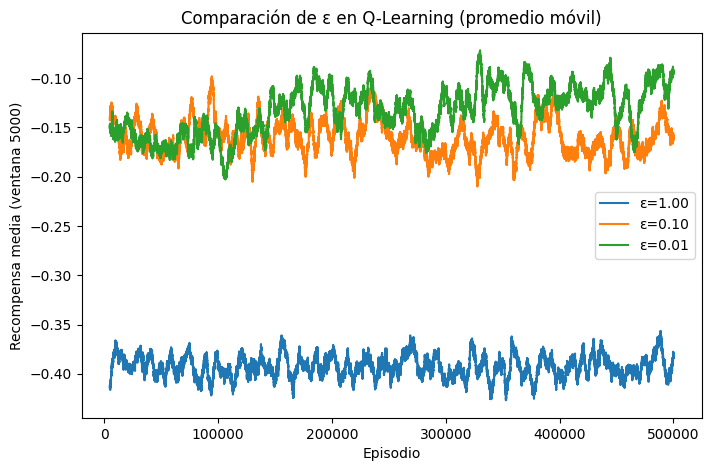

In [74]:
window = 5000  # tamaño de la ventana para suavizado
plt.figure(figsize=(8,5))

for name, data in results.items():
    # usamos recompensas totales por episodio y aplicamos promedio móvil
    rets = np.array(data['total_rewards'])
    smoothed = np.convolve(rets, np.ones(window)/window, mode='valid')
    episodes_axis = np.arange(window, window + len(smoothed))
    plt.plot(episodes_axis, smoothed, label=f"ε={epsilons[name]:.2f}")

plt.xlabel('Episodio')
plt.ylabel(f'Recompensa media (ventana {window})')
plt.title('Comparación de ε en Q-Learning (promedio móvil)')
plt.legend()
plt.show()

## 7. Evaluación en 10 000 episodios

In [75]:
def evaluate_with_std(policy_fn, n_episodes=10_000):
    wins = draws = losses = 0
    rewards = []
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = policy_fn(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        rewards.append(reward)
        if reward > 0:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1
    p_w = wins / n_episodes
    p_d = draws / n_episodes
    p_l = losses / n_episodes
    sigma_w = math.sqrt(p_w * (1 - p_w) / n_episodes)
    sigma_d = math.sqrt(p_d * (1 - p_d) / n_episodes)
    sigma_l = math.sqrt(p_l * (1 - p_l) / n_episodes)
    mean_ret = np.mean(rewards)
    sigma_ret = np.std(rewards)
    return (p_w, sigma_w, p_d, sigma_d, p_l, sigma_l, mean_ret, sigma_ret)

metrics = {}
n_eval = 10000
for name, data in results.items():
    Q = data['Q']
    def policy_fn(s, Q=Q):
        ps = s[0] - 4; dc = s[1] - 1; ua = int(s[2])
        return int(np.argmax(Q[ps, dc, ua]))
    p_w, σ_w, p_d, σ_d, p_l, σ_l, avg_ret, σ_ret = evaluate_with_std(policy_fn, n_episodes=n_eval)
    metrics[name] = {'victories': (p_w, σ_w), 'draws': (p_d, σ_d), 'losses': (p_l, σ_l), 'return': (avg_ret, σ_ret)}

import pandas as pd
df = pd.DataFrame([
    {
        'ε': f"{epsilons[name]:.2f}",
        'Victorias (%)': f"{metrics[name]['victories'][0]*100:.2f}±{metrics[name]['victories'][1]*100:.2f}",
        'Empates (%)':   f"{metrics[name]['draws'][0]*100:.2f}±{metrics[name]['draws'][1]*100:.2f}",
        'Derrotas (%)':  f"{metrics[name]['losses'][0]*100:.2f}±{metrics[name]['losses'][1]*100:.2f}",
        'Retorno medio': f"{metrics[name]['return'][0]:.3f}±{metrics[name]['return'][1]:.3f}"
    }
    for name in results
]).set_index('ε')
print("\nEvaluación de modelos Q-Learning (10k episodios):\n")
display(df)


Evaluación de modelos Q-Learning (10k episodios):



,Victorias (%),Empates (%),Derrotas (%),Retorno medio
ε,,,,
1.00,38.91±0.49,5.90±0.24,55.19±0.50,-0.163±0.956
0.10,37.93±0.49,6.28±0.24,55.79±0.50,-0.179±0.951
0.01,40.14±0.49,8.17±0.27,51.69±0.50,-0.116±0.951


In [76]:
best_tag = max(metrics, key=lambda n: metrics[n]['return'][0])
best_Q = results[best_tag]['Q']
print(f"\nMejor ε (por retorno medio): {epsilons[best_tag]:.2f} -> Retorno medio = {metrics[best_tag]['return'][0]:.3f}±{metrics[best_tag]['return'][1]:.3f}")


Mejor ε (por retorno medio): 0.01 -> Retorno medio = -0.116±0.951


## 7. Mapa de calor de la política aprendida

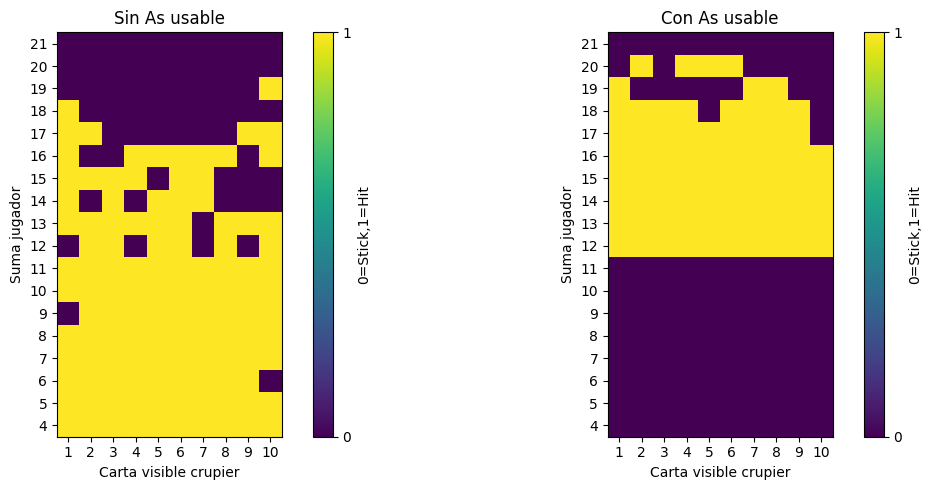

In [77]:
policy_no_ace = np.zeros((22,10))
policy_ace    = np.zeros((22,10))
for player in range(4,22):
    for dealer in range(1,11):
        for ace in [False, True]:
            ps = player-4; dc = dealer-1; ua = int(ace)
            a = np.argmax(best_Q[ps,dc,ua])
            if ace:
                policy_ace[player, dealer-1] = a
            else:
                policy_no_ace[player, dealer-1] = a
fig,axes = plt.subplots(1,2,figsize=(12,5))
im0 = axes[0].imshow(policy_no_ace[4:],origin='lower')
axes[0].set(title='Sin As usable')
im1 = axes[1].imshow(policy_ace[4:],origin='lower')
axes[1].set(title='Con As usable')
for ax in axes:
    ax.set_xlabel('Carta visible crupier'); ax.set_xticks(range(10)); ax.set_xticklabels(range(1,11))
    ax.set_ylabel('Suma jugador'); ax.set_yticks(range(18)); ax.set_yticklabels(range(4,22))
plt.colorbar(im0,ax=axes[0],ticks=[0,1],label='0=Stick,1=Hit')
plt.colorbar(im1,ax=axes[1],ticks=[0,1],label='0=Stick,1=Hit')
plt.tight_layout()
plt.show()


## 9. Demostración visual de la política

Recompensa episodio: 1.0


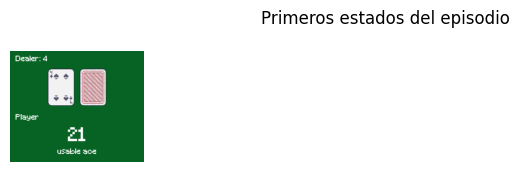

In [79]:
# Crear el entorno con renderizado
env_vis = gym.make("Blackjack-v1", render_mode="rgb_array")

# Ejecutar un episodio con la política óptima aprendida por Q-Learning
frames, total_reward = utils.run_and_render_episode(env_vis, policy_fn)

# Imprimir la recompensa del episodio
print("Recompensa episodio:", total_reward)

# Mostrar los primeros 5 frames como imágenes estáticas
plt.figure(figsize=(10, 2))
for i in range(min(5, len(frames))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(frames[i])
    plt.axis('off')  # Desactivar los ejes
plt.suptitle('Primeros estados del episodio')
plt.show()


## 10. Conclusiones

- El Q-Learning converge de forma estable tras una fase inicial de exploración.
- El rendimiento es modesto, con una media de -0.116 y 40.14% de victorias.
- Aún hay muchas derrotas, lo que indica margen de mejora en la política.
- Ajustar ε, α y γ podría mejorar la eficacia y estabilidad del aprendizaje.